<a href="https://colab.research.google.com/github/CarsonHhs/InventoryManagement/blob/main/OilPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM

In [340]:
df = pd.read_csv('/content/drive/MyDrive/Colab/Price.csv') #,parse_dates= ['Date'],dayfirst=True)
#df.set_index('Date', inplace=True)
#df =df.resample('m').sum()
#df.reset_index(inplace=True)

In [341]:
df['Date'] = pd.to_datetime(df['Date'])
#df = df.reindex(index= df.index[::-1])

In [342]:
#zaman = np.arange(1, len(df) + 1, 1)
OHCL_avg = df.mean(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



In [343]:
OHCL_avg = np.reshape(OHCL_avg.values, (len(OHCL_avg),1)) 

In [344]:
scaler = MinMaxScaler(feature_range=(0,1))
OHCL_avg = scaler.fit_transform(OHCL_avg)

In [345]:
#print(OHCL_avg)
train_OHLC = int(len(OHCL_avg)*0.9)
test_OHLC =  int(len(OHCL_avg)*0.1)

print(train_OHLC,test_OHLC)

train_OHLC, test_OHLC = OHCL_avg[0:train_OHLC,:], OHCL_avg[train_OHLC:len(OHCL_avg),:]

381 42


In [346]:
#output = activation(dot(input, kernel) + bias)

def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [347]:
step_size = 4

In [348]:
#Train the datasets and test it
trainX, trainY = new_dataset(train_OHLC,step_size)
testX, testY = new_dataset(test_OHLC,step_size)

In [349]:
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1]))

In [350]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, step_size)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('linear'))

In [351]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=25, verbose=2)

Epoch 1/10
16/16 - 2s - loss: 0.1080
Epoch 2/10
16/16 - 0s - loss: 0.0397
Epoch 3/10
16/16 - 0s - loss: 0.0166
Epoch 4/10
16/16 - 0s - loss: 0.0117
Epoch 5/10
16/16 - 0s - loss: 0.0090
Epoch 6/10
16/16 - 0s - loss: 0.0070
Epoch 7/10
16/16 - 0s - loss: 0.0050
Epoch 8/10
16/16 - 0s - loss: 0.0049
Epoch 9/10
16/16 - 0s - loss: 0.0037
Epoch 10/10
16/16 - 0s - loss: 0.0040


In [352]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [353]:
print(trainPredict.shape, testPredict.shape)

(376, 1) (38, 1)


In [354]:
a = np.empty((step_size+1,))
a [:]= np.nan
b = np.empty((int(testY.size+ step_size+1),))
b [:]= np.nan
c=trainPredict.reshape(trainY.size)
d = np.concatenate((a, c))
d= np.concatenate((d,b))
df['Train'] = d

In [355]:
a = np.empty((trainY.size+step_size*2+2,))
a [:]= np.nan
b=testPredict.reshape(testY.size,)
c = np.concatenate((a,b))
df['Test'] = c

In [356]:
!pip install "notebook>=5.3" "ipywidgets>=7.5"

In [357]:
df.tail(10)

,Date,Price,Train,Test
414,2020-07-01,40.71,NaN,30.517990
415,2020-08-01,42.34,NaN,29.355778
416,2020-09-01,39.63,NaN,32.721073
417,2020-10-01,39.40,NaN,38.049908
418,2020-11-01,40.94,NaN,40.059547
419,2020-12-01,47.02,NaN,40.137863
420,2021-01-01,52.00,NaN,40.169769
421,2021-02-01,59.04,NaN,41.608849
422,2021-03-01,62.33,NaN,44.766987
423,2021-04-01,61.72,NaN,49.631878


In [358]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(df.Date), y=list(df.Price), line=dict(color="green"), name= 'price')
    )

fig.add_trace(
    go.Scatter(x=list(df.Date), y=list(df.Train), line=dict(color="red"), name = 'Train')
    )

fig.add_trace(
    go.Scatter(x=list(df.Date), y=list(df.Test), line=dict(color="blue"), name = 'Test')
    )


# Set title
fig.update_layout(
    title_text="Time series with range slider and selectors"
)



In [359]:
# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

fig.show()

In [360]:
trainScore = math.sqrt(mean_squared_error(trainY[0], 
                       trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], 
                       testPredict[:,0]))

In [361]:
trainPredictPlot = np.empty_like(OHCL_avg)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size,:] = trainPredict

In [362]:
testPredictPlot = np.empty_like(OHCL_avg)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHCL_avg)-1,:] = testPredict

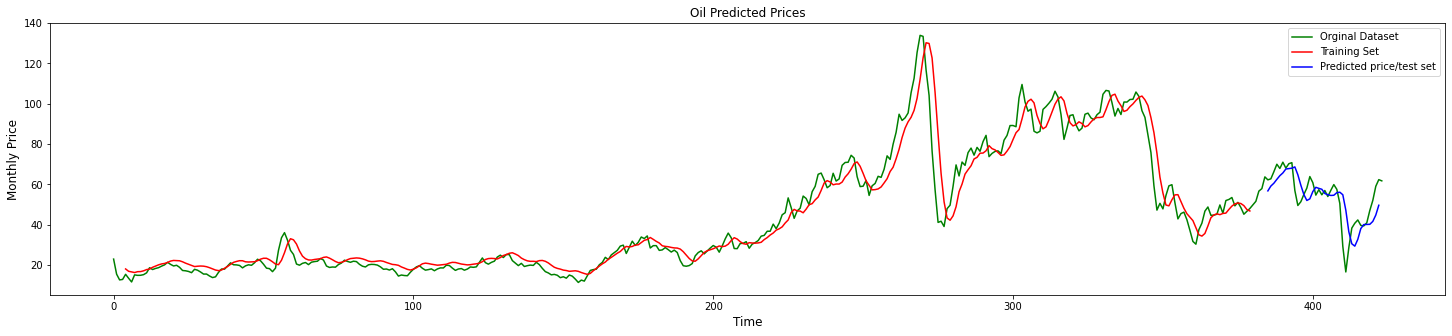

In [363]:
OHCL_avg = scaler.inverse_transform(OHCL_avg)
plt.figure(figsize=(25, 5))
plt.plot(OHCL_avg, 'g', label='Orginal Dataset')
plt.plot(trainPredictPlot, 'r', label='Training Set')
plt.plot(testPredictPlot, 'b', label='Predicted price/test set')
plt.title("Oil Predicted Prices")
plt.xlabel('Time', fontsize=12)
plt.ylabel('Monthly Price', fontsize=12)
plt.legend(loc='upper right')
plt.show()